In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as ltb
from sklearn.neural_network import MLPClassifier
from copy import deepcopy
import warnings


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

warnings.filterwarnings('ignore')

# Read train/test data (overlapping window size is 200ms, std)

In [9]:
trainx = pd.read_csv('traintestdata/std_window_200ms/trainx_std.csv')
trainy = pd.read_csv('traintestdata/std_window_200ms/trainy_std.csv')
testx1 = pd.read_csv('traintestdata/std_window_200ms/testx1_std.csv')
testy1 = pd.read_csv('traintestdata/std_window_200ms/testy1_std.csv')

# Find transition data accuracy

In [10]:
def find_diff_window_acc(window_size):
    acc_list = []
    for transition_size in tqdm((window_size)):
        # find the ten start point
        # ten_start_point is for the testing data set #2
        counter = 0
        label_number = [1,2,3,4,5,6,7,8,9,10]
        checked_label = []
        ten_start_point = []
        for i in label_number:
            for j in range(0, len(testy1)):
                if testy1.iloc[j,0] == i:
                    if i not in checked_label:
                        counter += 1
                        checked_label.append(i)
                        ten_start_point.append(j)
                if counter == 10:
                    break

        # find the ten new end point
        # ten_end_point is for the testing data set #2
        last = 1
        ten_end_point = []
        label_number = [1,2,3,4,5,6,7,8,9,10]
        for j in label_number:
            last = j
            counter = 0
            for i in range(ten_start_point[j-1], len(testy1)):
                if i == len(testy1)-1:
                    ten_end_point.append(i)
                current = testy1.iloc[i,0]
                if last == current:
                    last = current
                else:
                    last = current
                    counter += 1
                if counter == 1:
                    ten_end_point.append(i)
                    break

        testx2 = testx1.iloc[ten_start_point[0]:ten_start_point[0]+transition_size, :]
        testx2 = testx2.append(testx1.iloc[ten_end_point[0]:ten_end_point[0]+transition_size, :])

        for i in range(1,10):
            testx2 = testx2.append(testx1.iloc[ten_start_point[i]:ten_start_point[i]+transition_size, :])
            testx2 = testx2.append(testx1.iloc[ten_end_point[i]:ten_end_point[i]+transition_size, :])

        testy2 = testy1.iloc[ten_start_point[0]:ten_start_point[0]+transition_size, :]
        testy2 = testy2.append(testy1.iloc[ten_end_point[0]:ten_end_point[0]+transition_size, :])

        for i in range(1,10):
            testy2 = testy2.append(testy1.iloc[ten_start_point[i]:ten_start_point[i]+transition_size, :])
            testy2 = testy2.append(testy1.iloc[ten_end_point[i]:ten_end_point[i]+transition_size, :])
            
        lightGBM_model = ltb.LGBMClassifier()
        lightGBM_model.fit(trainx,trainy)

        expected2 = testy2.values.flatten()
        predicted2 = lightGBM_model.predict(testx2)

        counter = 0
        for i in range(0, len(expected2)):
            if expected2[i] == predicted2[i]:
                counter += 1

        accuracy2 = counter/len(expected2)
        acc_list.append(accuracy2)
    return acc_list

In [11]:
window_size = [83, 166, 250, 332, 415, 500]
acc = find_diff_window_acc(window_size)

In [12]:
acc

[0.3614457831325301,
 0.3189759036144578,
 0.3108,
 0.35602409638554217,
 0.39397590361445783,
 0.4295]

# Plot results

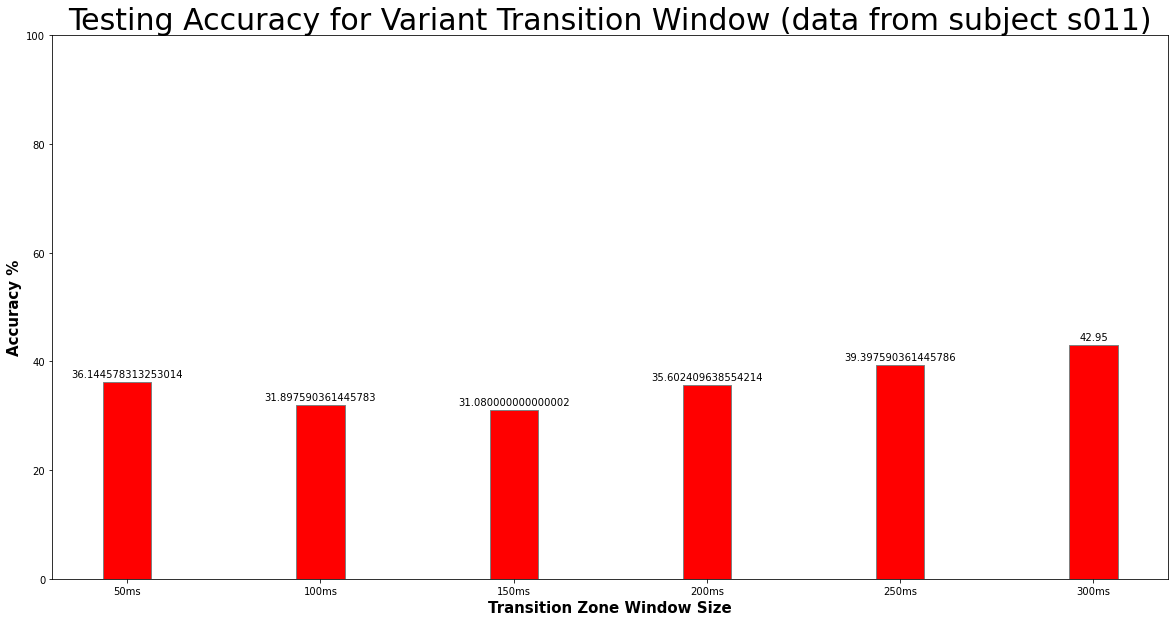

In [14]:
# set width of bar
barWidth = 0.25
fig,ax = plt.subplots(figsize =(20, 10))

# set height of bar
acc_percentage = []
for i in acc:
    acc_percentage.append(i *100)

# Set position of bar on X axis
bar1_index = np.arange(len(acc_percentage))

# Make the plot
bar1 = ax.bar(bar1_index, acc_percentage, color ='r', width = barWidth, edgecolor ='grey')
for p in bar1:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

# Adding Xticks
ax.set_xlabel('Transition Zone Window Size', fontweight ='bold', fontsize = 15)
ax.set_ylabel('Accuracy %', fontweight ='bold', fontsize = 15)
ax.set_xticks(bar1_index)
ax.set_xticklabels(['50ms', '100ms', '150ms', '200ms', '250ms', '300ms'])

ax.set_ylim(0, 100)
ax.set_title('Testing Accuracy for Variant Transition Window (data from subject s011)',size=30)
# ax.legend()
plt.show();